In [16]:
'''
Simulations to test the behavior of MOS when we vary the hyperparameters.
'''

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col


import warnings
warnings.filterwarnings("ignore")

# Print df_degfieldd without truncation
pd.set_option('display.max_rows', None)


In [17]:
def compute_mci_hajime(A, At=None, mci_init=None, iter=250, output_other_side=False):
    M, N = A.shape
    if mci_init is None:
        assert np.all(np.isin(A,[0,1])), "A must be binary matrix if mci_init is not provided."
        mci_init = A.sum(axis=1)
    mci = mci_init.copy().values.reshape([-1,1])
    if At is None:
        At = A.T
    Aw = A/np.sum(A,axis=1).values.reshape(M,1)
    Atw = At/np.sum(At,axis=1).values.reshape(N,1)

    result_mci = pd.DataFrame(index=A.index)
    result_mci[f'iter_{0}'] = mci
    result_oci = pd.DataFrame(index=A.columns)
    for i in range(iter):
        oci = np.dot(Atw,mci)
        mci = np.dot(Aw,oci)
        # oci = (oci - oci.mean())/oci.std()
        # mci = (mci - mci.mean())/mci.std()
        oci = (oci - oci.min())/(oci.max()-oci.min()) + 1e-5
        mci = (mci - mci.min())/(mci.max()-mci.min()) + 1e-5
        result_mci[f'iter_{i+1}'] = mci
        result_oci[f'iter_{i+1}'] = oci
    if output_other_side:
        return result_mci, result_oci
    else:
        return result_mci


def binarize_by_rca(df_adj,binarize_threshold=1.):
    # Construct the binary matrix.
    ## Methods: Threshold with certain number, or revealed comparative advantage.
    binarize_method='rca'
    major_share = (df_adj.T/df_adj.sum(axis=1) ).T #Share of an occupation within a major
    if binarize_method == 'rca':
        occupation_share = df_adj.sum(axis=0)/df_adj.sum().sum()
        rca = major_share/occupation_share
        major_occupation_matrix = (rca>binarize_threshold).astype(int)

    return major_occupation_matrix




In [18]:
df_degfield = pd.read_csv('../data/processed_data/acs/degfield_mapping.csv', index_col=0)
df_degfieldd = pd.read_csv('../data/processed_data/acs/degfieldd_mapping.csv', index_col=0)
# 24 is engineering. 37	mathematics and statistics

major_ref_top_degfield = 21 #computer and information sciences
major_ref_bottom_degfield = 60 #fine arts
major_ref_top_degfieldd = 2102 #computer science
major_ref_bottom_degfieldd = 6000 #drama and theater arts

iterations = 25
binarize_method = 'rca'

soc_level = 4
major_var = 'degfieldd'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
df_wage['major_d'] = df_wage_['major']
df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
df_wage['occupation_4'] = df_wage_d_['occupation']



## 1. Varying RCA threshold

In [19]:
for soc_level in [4]:
    for major_var in ['degfieldd']:
        major_name = df_degfield if major_var == 'degfield' else df_degfieldd
        major_name.index.name = 'major'
        adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

        # df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
        # df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
        # df_wage['major_d'] = df_wage_['major']
        # df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
        # df_wage['occupation_4'] = df_wage_d_['occupation']


        rankings = []
        mcis = []
        thresholds = [.5,1., 1.25,1.5,1.75, 2.]
        mci_coeffs = []
        mci_coeffs_std = []
        for threshold in thresholds:
            binary_matrix = binarize_by_rca(adj_matrix,binarize_threshold=threshold)
            mci = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking = mci.iloc[:,-1].rank(ascending=True)
            # Adjust the direction
            major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
            major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
            if ranking[major_ref_top]>ranking[major_ref_bottom]:
                mci = -mci
                ranking = mci.iloc[:,-1].rank(ascending=True)

            rankings.append(ranking)
            mcis.append(mci.iloc[:,-1])

            scaler = StandardScaler()
            mci_normalized = pd.DataFrame(scaler.fit_transform(mci.iloc[:,[-1]]), index=mci.index)
            mci_normalized.columns = ['MCI']
            mci_normalized.index.name = 'major_d' if major_var == 'degfieldd' else 'major'
            df_wage_with_mci = df_wage.merge(mci_normalized,on='major_d',how='left')


            # Regression
            X_wage = pd.concat([pd.get_dummies(df_wage_with_mci['year'], prefix='year',drop_first=True),df_wage_with_mci[['white','hispanic','sex']],df_wage_with_mci[['experience','experience_sq']]], axis=1) #pd.get_dummies(df_wage['major'], prefix='major',drop_first=True),
            y_wage = df_wage_with_mci['incwage_cpiu_2010'].apply(np.log1p).rename('log_wage')
            major_wage = df_wage_with_mci['major']
            ## Generate an integer index for each major-year pair for clustering
            major_year_wage = df_wage_with_mci['major_d'].astype(str) + df_wage_with_mci['year'].astype(str)
            major_year_wage = major_year_wage.astype('category').cat.codes

            X_ = pd.concat([X_wage,df_wage_with_mci[['MCI']]], axis=1)
            X_ = X_.astype(float)
            model = sm.OLS
            cov_type = 'cluster' 
            cov_kwds = {'groups': major_year_wage}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            result = model(y_wage, sm.add_constant( X_.copy() )).fit(**fit_args)
            mci_coeffs.append(result.summary2().tables[1].loc['MCI']['Coef.'])
            mci_coeffs_std.append(result.summary2().tables[1].loc['MCI']['Std.Err.'])


        rankings_df = pd.concat(rankings, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])
        mcis_df = pd.concat(mcis, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])









No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


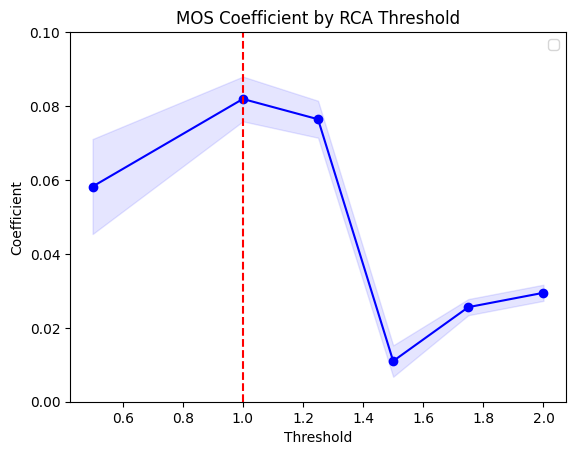

In [21]:
coef_seq = pd.Series(np.abs(mci_coeffs),index=thresholds)
std_seq = pd.Series(mci_coeffs_std,index=thresholds)
# Plot
fig, ax = plt.subplots()
coef_seq.plot(ax=ax, marker='o', color='b')
ax.fill_between(coef_seq.index, coef_seq-std_seq, coef_seq+std_seq, color='b', alpha=.1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Coefficient')
ax.set_title('MOS Coefficient by RCA Threshold')
# Red dashed line at x=1
ax.axvline(x=1, color='r', linestyle='--')
ax.set_ylim(0, .1)

plt.legend()
plt.savefig(f'../results_JHR_revision2/mci_coeff_rca_threshold.pdf')
plt.show()


In [22]:
coef_seq

0.50    0.058215
1.00    0.081915
1.25    0.076429
1.50    0.011000
1.75    0.025590
2.00    0.029474
dtype: float64

## 2. Varying the node threshold for majors.

In [6]:
for soc_level in [4]:
    for major_var in ['degfieldd']:
        major_name = df_degfield if major_var == 'degfield' else df_degfieldd
        major_name.index.name = 'major'
        adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

        # df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
        # df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
        # df_wage['major_d'] = df_wage_['major']
        # df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
        # df_wage['occupation_4'] = df_wage_d_['occupation']


        rankings = []
        mcis = []
        thresholds = [100,200,400,800]
        mci_coeffs = []
        mci_coeffs_std = []
        for threshold in thresholds:
            adj_matrix_cut = adj_matrix.copy()
            # Check the sum of each row
            adj_matrix_cut['major_sum'] = adj_matrix_cut.sum(axis=1)
            adj_matrix_cut = adj_matrix_cut[adj_matrix_cut['major_sum']>=threshold]
            adj_matrix_cut = adj_matrix_cut.drop(columns='major_sum')
            # Check the sum of each column
            adj_matrix_cut.loc['occupation_sum',:] = adj_matrix_cut.sum(axis=0)
            adj_matrix_cut = adj_matrix_cut.loc[:,adj_matrix_cut.loc['occupation_sum']>0]
            adj_matrix_cut = adj_matrix_cut.drop(index='occupation_sum')
            #
            print('Original shape:', adj_matrix.shape, 'Result shape:', adj_matrix_cut.shape)

            binary_matrix = binarize_by_rca(adj_matrix_cut,binarize_threshold=1.0)
            mci = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking = mci.iloc[:,-1].rank(ascending=True)
            # Adjust the direction
            major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
            major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
            if ranking[major_ref_top]>ranking[major_ref_bottom]:
                mci = -mci
                ranking = mci.iloc[:,-1].rank(ascending=True)

            rankings.append(ranking)
            mcis.append(mci.iloc[:,-1])

            scaler = StandardScaler()
            mci_normalized = pd.DataFrame(scaler.fit_transform(mci.iloc[:,[-1]]), index=mci.index)
            mci_normalized.columns = ['MCI']
            mci_normalized.index.name = 'major_d' if major_var == 'degfieldd' else 'major'
            df_wage_with_mci = df_wage.merge(mci_normalized,on='major_d',how='left')


            # Regression
            X_wage = pd.concat([pd.get_dummies(df_wage_with_mci['year'], prefix='year',drop_first=True),df_wage_with_mci[['white','hispanic','sex']],df_wage_with_mci[['experience','experience_sq']]], axis=1) #pd.get_dummies(df_wage['major'], prefix='major',drop_first=True),
            y_wage = df_wage_with_mci['incwage_cpiu_2010'].apply(np.log1p).rename('log_wage')
            major_wage = df_wage_with_mci['major']
            ## Generate an integer index for each major-year pair for clustering
            major_year_wage = df_wage_with_mci['major_d'].astype(str) + df_wage_with_mci['year'].astype(str)
            major_year_wage = major_year_wage.astype('category').cat.codes

            X_ = pd.concat([X_wage,df_wage_with_mci[['MCI']]], axis=1)
            X_ = X_.astype(float)

            #
            X_.dropna(inplace=True)
            y_wage_ = y_wage.loc[X_.index]
            major_year_wage_ = major_year_wage.loc[X_.index]
            
            model = sm.OLS
            cov_type = 'cluster' 
            cov_kwds = {'groups': major_year_wage_}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            result = model(y_wage_.copy(), sm.add_constant( X_.copy() )).fit(**fit_args)
            mci_coeffs.append(result.summary2().tables[1].loc['MCI']['Coef.'])
            mci_coeffs_std.append(result.summary2().tables[1].loc['MCI']['Std.Err.'])


        rankings_df = pd.concat(rankings, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])
        mcis_df = pd.concat(mcis, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])









Original shape: (159, 97) Result shape: (159, 97)
Original shape: (159, 97) Result shape: (150, 97)
Original shape: (159, 97) Result shape: (130, 97)
Original shape: (159, 97) Result shape: (113, 97)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


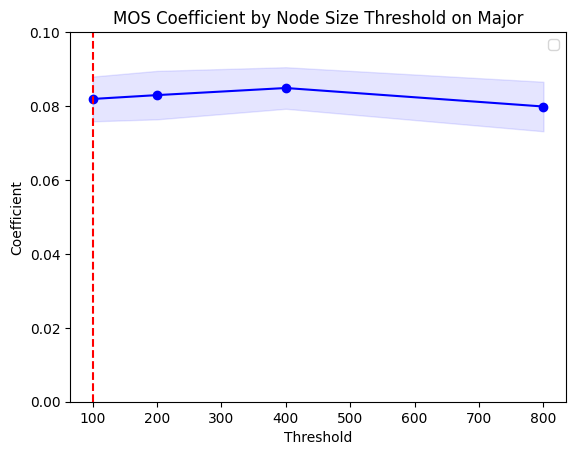

In [7]:
coef_seq = pd.Series(np.abs(mci_coeffs),index=thresholds)
std_seq = pd.Series(mci_coeffs_std,index=thresholds)
# Plot
fig, ax = plt.subplots()
coef_seq.plot(ax=ax, marker='o', color='b')
ax.fill_between(coef_seq.index, coef_seq-std_seq, coef_seq+std_seq, color='b', alpha=.1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Coefficient')
ax.set_title('MOS Coefficient by Node Size Threshold on Major')
# Red dashed line at x=100
ax.axvline(x=100, color='r', linestyle='--')
# y-axis range from 0
ax.set_ylim(0, .1)

plt.legend()
plt.savefig(f'../results_JHR_revision2/mci_coeff_node_size_threshold.pdf')
plt.show()


In [8]:
for soc_level in [4]:
    for major_var in ['degfieldd']:
        major_name = df_degfield if major_var == 'degfield' else df_degfieldd
        major_name.index.name = 'major'
        adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

        # df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
        # df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
        # df_wage['major_d'] = df_wage_['major']
        # df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
        # df_wage['occupation_4'] = df_wage_d_['occupation']


        rankings = []
        mcis = []
        thresholds = [100,200,400,800]
        mci_coeffs = []
        mci_coeffs_std = []
        for threshold in thresholds:
            adj_matrix_cut = adj_matrix.copy()
            # Check the sum of each column
            adj_matrix_cut.loc['occupation_sum',:] = adj_matrix_cut.sum(axis=0)
            adj_matrix_cut = adj_matrix_cut.loc[:,adj_matrix_cut.loc['occupation_sum']>=threshold]
            adj_matrix_cut = adj_matrix_cut.drop(index='occupation_sum')
            # Check the sum of each row
            adj_matrix_cut['major_sum'] = adj_matrix_cut.sum(axis=1)
            adj_matrix_cut = adj_matrix_cut[adj_matrix_cut['major_sum']>0]
            adj_matrix_cut = adj_matrix_cut.drop(columns='major_sum')
            #
            print('Original shape:', adj_matrix.shape, 'Result shape:', adj_matrix_cut.shape)

            binary_matrix = binarize_by_rca(adj_matrix_cut,binarize_threshold=1.0)
            mci = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking = mci.iloc[:,-1].rank(ascending=True)
            # Adjust the direction
            major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
            major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
            if ranking[major_ref_top]>ranking[major_ref_bottom]:
                mci = -mci
                ranking = mci.iloc[:,-1].rank(ascending=True)

            rankings.append(ranking)
            mcis.append(mci.iloc[:,-1])

            scaler = StandardScaler()
            mci_normalized = pd.DataFrame(scaler.fit_transform(mci.iloc[:,[-1]]), index=mci.index)
            mci_normalized.columns = ['MCI']
            mci_normalized.index.name = 'major_d' if major_var == 'degfieldd' else 'major'
            df_wage_with_mci = df_wage.merge(mci_normalized,on='major_d',how='left')


            # Regression
            X_wage = pd.concat([pd.get_dummies(df_wage_with_mci['year'], prefix='year',drop_first=True),df_wage_with_mci[['white','hispanic','sex']],df_wage_with_mci[['experience','experience_sq']]], axis=1) #pd.get_dummies(df_wage['major'], prefix='major',drop_first=True),
            y_wage = df_wage_with_mci['incwage_cpiu_2010'].apply(np.log1p).rename('log_wage')
            major_wage = df_wage_with_mci['major']
            ## Generate an integer index for each major-year pair for clustering
            major_year_wage = df_wage_with_mci['major_d'].astype(str) + df_wage_with_mci['year'].astype(str)
            major_year_wage = major_year_wage.astype('category').cat.codes

            X_ = pd.concat([X_wage,df_wage_with_mci[['MCI']]], axis=1)
            X_ = X_.astype(float)

            #
            X_.dropna(inplace=True)
            y_wage_ = y_wage.loc[X_.index]
            major_year_wage_ = major_year_wage.loc[X_.index]
            
            model = sm.OLS
            cov_type = 'cluster' 
            cov_kwds = {'groups': major_year_wage_}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            result = model(y_wage_.copy(), sm.add_constant( X_.copy() )).fit(**fit_args)
            mci_coeffs.append(result.summary2().tables[1].loc['MCI']['Coef.'])
            mci_coeffs_std.append(result.summary2().tables[1].loc['MCI']['Std.Err.'])


        rankings_df = pd.concat(rankings, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])
        mcis_df = pd.concat(mcis, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])









Original shape: (159, 97) Result shape: (159, 97)
Original shape: (159, 97) Result shape: (159, 94)
Original shape: (159, 97) Result shape: (159, 83)
Original shape: (159, 97) Result shape: (159, 72)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


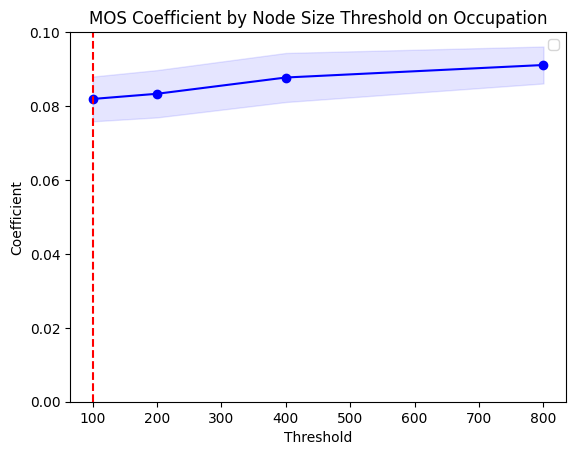

In [9]:
coef_seq = pd.Series(np.abs(mci_coeffs),index=thresholds)
std_seq = pd.Series(mci_coeffs_std,index=thresholds)
# Plot
fig, ax = plt.subplots()
coef_seq.plot(ax=ax, marker='o', color='b')
ax.fill_between(coef_seq.index, coef_seq-std_seq, coef_seq+std_seq, color='b', alpha=.1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Coefficient')
ax.set_title('MOS Coefficient by Node Size Threshold on Occupation')
# Red dashed line at x=100
ax.axvline(x=100, color='r', linestyle='--')
# y-axis range from 0
ax.set_ylim(0, .1)

plt.legend()
plt.savefig(f'../results_JHR_revision2/mci_coeff_node_size_threshold_occ.pdf')
plt.show()


### RCA graph based on stricter cutoff

In [10]:
for soc_level in [4]:
    for major_var in ['degfieldd']:
        major_name = df_degfield if major_var == 'degfield' else df_degfieldd
        major_name.index.name = 'major'
        adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

        # df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
        # df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
        # df_wage['major_d'] = df_wage_['major']
        # df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
        # df_wage['occupation_4'] = df_wage_d_['occupation']


        rankings = []
        mcis = []
        thresholds = [.5,1., 1.25,1.5,1.75, 2.]
        mci_coeffs = []
        mci_coeffs_std = []
        for threshold in thresholds:
            adj_matrix_cut = adj_matrix.copy()
            # Check the sum of each column
            adj_matrix_cut.loc['occupation_sum',:] = adj_matrix_cut.sum(axis=0)
            adj_matrix_cut = adj_matrix_cut.loc[:,adj_matrix_cut.loc['occupation_sum']>=800]
            adj_matrix_cut = adj_matrix_cut.drop(index='occupation_sum')
            # Check the sum of each row
            adj_matrix_cut['major_sum'] = adj_matrix_cut.sum(axis=1)
            adj_matrix_cut = adj_matrix_cut[adj_matrix_cut['major_sum']>0]
            adj_matrix_cut = adj_matrix_cut.drop(columns='major_sum')
            #
            print('Original shape:', adj_matrix.shape, 'Result shape:', adj_matrix_cut.shape)

            binary_matrix = binarize_by_rca(adj_matrix_cut,binarize_threshold=threshold)
            mci = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking = mci.iloc[:,-1].rank(ascending=True)
            # Adjust the direction
            major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
            major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
            if ranking[major_ref_top]>ranking[major_ref_bottom]:
                mci = -mci
                ranking = mci.iloc[:,-1].rank(ascending=True)

            rankings.append(ranking)
            mcis.append(mci.iloc[:,-1])

            scaler = StandardScaler()
            mci_normalized = pd.DataFrame(scaler.fit_transform(mci.iloc[:,[-1]]), index=mci.index)
            mci_normalized.columns = ['MCI']
            mci_normalized.index.name = 'major_d' if major_var == 'degfieldd' else 'major'
            df_wage_with_mci = df_wage.merge(mci_normalized,on='major_d',how='left')


            # Regression
            X_wage = pd.concat([pd.get_dummies(df_wage_with_mci['year'], prefix='year',drop_first=True),df_wage_with_mci[['white','hispanic','sex']],df_wage_with_mci[['experience','experience_sq']]], axis=1) #pd.get_dummies(df_wage['major'], prefix='major',drop_first=True),
            y_wage = df_wage_with_mci['incwage_cpiu_2010'].apply(np.log1p).rename('log_wage')
            major_wage = df_wage_with_mci['major']
            ## Generate an integer index for each major-year pair for clustering
            major_year_wage = df_wage_with_mci['major_d'].astype(str) + df_wage_with_mci['year'].astype(str)
            major_year_wage = major_year_wage.astype('category').cat.codes

            X_ = pd.concat([X_wage,df_wage_with_mci[['MCI']]], axis=1)
            X_ = X_.astype(float)
            model = sm.OLS
            cov_type = 'cluster' 
            cov_kwds = {'groups': major_year_wage}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            result = model(y_wage, sm.add_constant( X_.copy() )).fit(**fit_args)
            mci_coeffs.append(result.summary2().tables[1].loc['MCI']['Coef.'])
            mci_coeffs_std.append(result.summary2().tables[1].loc['MCI']['Std.Err.'])


        rankings_df = pd.concat(rankings, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])
        mcis_df = pd.concat(mcis, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])









Original shape: (159, 97) Result shape: (159, 72)
Original shape: (159, 97) Result shape: (159, 72)
Original shape: (159, 97) Result shape: (159, 72)
Original shape: (159, 97) Result shape: (159, 72)
Original shape: (159, 97) Result shape: (159, 72)
Original shape: (159, 97) Result shape: (159, 72)


(0.0, 0.1)

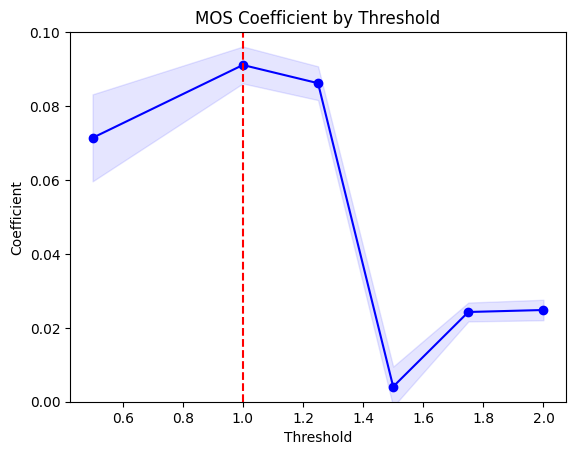

In [11]:
coef_seq = pd.Series(np.abs(mci_coeffs),index=thresholds)
std_seq = pd.Series(mci_coeffs_std,index=thresholds)
# Plot
fig, ax = plt.subplots()
coef_seq.plot(ax=ax, marker='o', color='b')
ax.fill_between(coef_seq.index, coef_seq-std_seq, coef_seq+std_seq, color='b', alpha=.1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Coefficient')
ax.set_title('MOS Coefficient by Threshold')
# Red dashed line at x=1
ax.axvline(x=1, color='r', linestyle='--')
ax.set_ylim(0, .1)


## (Dropping links with only 1 student for Xiao)

In [12]:
for soc_level in [4]:
    for major_var in ['degfieldd']:
        major_name = df_degfield if major_var == 'degfield' else df_degfieldd
        major_name.index.name = 'major'
        adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

        # df_wage = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{2}.csv',index_col=0)
        # df_wage_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfieldd"}_soc{2}.csv',index_col=0)
        # df_wage['major_d'] = df_wage_['major']
        # df_wage_d_ = pd.read_csv(f'../data/processed_data/acs/df_reg_{"degfield"}_soc{4}.csv',index_col=0)
        # df_wage['occupation_4'] = df_wage_d_['occupation']


        rankings = []
        mcis = []
        thresholds = [1,2,4,8]
        mci_coeffs = []
        mci_coeffs_std = []
        for threshold in thresholds:
            adj_matrix_cut = adj_matrix.copy()
            # Check the size of each entry and set it zero if it's below 2
            adj_matrix_cut[adj_matrix_cut<threshold] = 0
            # Check the sum of each column
            adj_matrix_cut.loc['occupation_sum',:] = adj_matrix_cut.sum(axis=0)
            adj_matrix_cut = adj_matrix_cut.loc[:,adj_matrix_cut.loc['occupation_sum']>0]
            adj_matrix_cut = adj_matrix_cut.drop(index='occupation_sum')
            # Check the sum of each row
            adj_matrix_cut['major_sum'] = adj_matrix_cut.sum(axis=1)
            adj_matrix_cut = adj_matrix_cut[adj_matrix_cut['major_sum']>0]
            adj_matrix_cut = adj_matrix_cut.drop(columns='major_sum')

            #
            print('Original shape:', adj_matrix.shape, 'Result shape:', adj_matrix_cut.shape)

            binary_matrix = binarize_by_rca(adj_matrix_cut,binarize_threshold=1.0)
            mci = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking = mci.iloc[:,-1].rank(ascending=True)
            # Adjust the direction
            major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
            major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
            if ranking[major_ref_top]>ranking[major_ref_bottom]:
                mci = -mci
                ranking = mci.iloc[:,-1].rank(ascending=True)

            rankings.append(ranking)
            mcis.append(mci.iloc[:,-1])

            scaler = StandardScaler()
            mci_normalized = pd.DataFrame(scaler.fit_transform(mci.iloc[:,[-1]]), index=mci.index)
            mci_normalized.columns = ['MCI']
            mci_normalized.index.name = 'major_d' if major_var == 'degfieldd' else 'major'
            df_wage_with_mci = df_wage.merge(mci_normalized,on='major_d',how='left')


            # Regression
            X_wage = pd.concat([pd.get_dummies(df_wage_with_mci['year'], prefix='year',drop_first=True),df_wage_with_mci[['white','hispanic','sex']],df_wage_with_mci[['experience','experience_sq']]], axis=1) #pd.get_dummies(df_wage['major'], prefix='major',drop_first=True),
            y_wage = df_wage_with_mci['incwage_cpiu_2010'].apply(np.log1p).rename('log_wage')
            major_wage = df_wage_with_mci['major']
            ## Generate an integer index for each major-year pair for clustering
            major_year_wage = df_wage_with_mci['major_d'].astype(str) + df_wage_with_mci['year'].astype(str)
            major_year_wage = major_year_wage.astype('category').cat.codes

            X_ = pd.concat([X_wage,df_wage_with_mci[['MCI']]], axis=1)
            X_ = X_.astype(float)
            model = sm.OLS
            cov_type = 'cluster' 
            cov_kwds = {'groups': major_year_wage}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            fit_args = {'cov_type':cov_type, 'cov_kwds':cov_kwds}
            result = model(y_wage, sm.add_constant( X_.copy() )).fit(**fit_args)
            mci_coeffs.append(result.summary2().tables[1].loc['MCI']['Coef.'])
            mci_coeffs_std.append(result.summary2().tables[1].loc['MCI']['Std.Err.'])


        rankings_df = pd.concat(rankings, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])
        mcis_df = pd.concat(mcis, axis=1, keys=[f'threshold_{threshold}' for threshold in thresholds])









Original shape: (159, 97) Result shape: (159, 97)
Original shape: (159, 97) Result shape: (159, 97)
Original shape: (159, 97) Result shape: (159, 97)
Original shape: (159, 97) Result shape: (159, 97)


(0.0, 0.1)

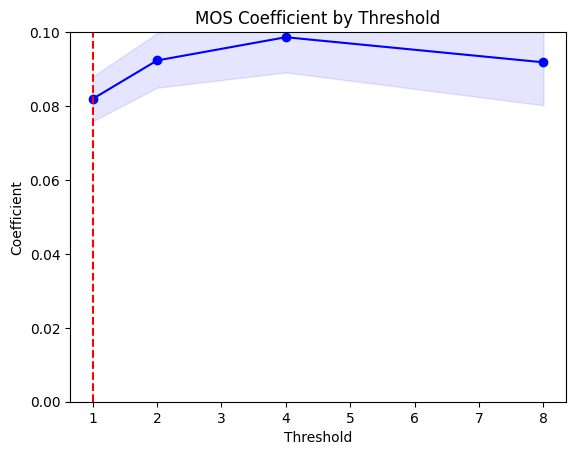

In [13]:
coef_seq = pd.Series(np.abs(mci_coeffs),index=thresholds)
std_seq = pd.Series(mci_coeffs_std,index=thresholds)
# Plot
fig, ax = plt.subplots()
coef_seq.plot(ax=ax, marker='o', color='b')
ax.fill_between(coef_seq.index, coef_seq-std_seq, coef_seq+std_seq, color='b', alpha=.1)
ax.set_xlabel('Threshold')
ax.set_ylabel('Coefficient')
ax.set_title('MOS Coefficient by Threshold')
# Red dashed line at x=1
ax.axvline(x=1, color='r', linestyle='--')
ax.set_ylim(0, .1)


In [14]:
rankings_df.corr(method='spearman')

,threshold_1,threshold_2,threshold_4,threshold_8
threshold_1,1.000000,0.983413,0.936849,0.863578
threshold_2,0.983413,1.000000,0.960909,0.888515
threshold_4,0.936849,0.960909,1.000000,0.952953
threshold_8,0.863578,0.888515,0.952953,1.000000
